VGGについて構造の説明と実装を行います。
ただし、論文すべてを見るわけでなく構造のところを中心に見ていきます。


入力画像は224×224のRGB画像とします。前処理として、平均RGB値を各ピクセルから引きます。
カーネルサイズが3×3のフィルタを使用しますが、線形変換として見ることができる1×1の畳み込みフィルタも使用します。
ストライドは1で、パディングは3×3の畳み込み処理に対して1ピクセルとします。
プーリング層としては最大プーリングを使用し、いくつかの畳み込み層のあとに配置します。プーリングは、カーネルサイズは2×2でストライドを2で実行します。

上記の畳み込み層に3つの全結合層が続きます。
最初の2つはそれぞれ4096チャンネルを持ち、3つ目の層は1000チャンネル(ILSVRの分類問題のクラス数)をもっています。最後の層はソフトマックス関数を使用します。

すべての隠れ層は非線形の整流性(ReLU)を持っていますが、1つを除いてLocal Response Normalizationを持っていません。

In [1]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10
import numpy as np
import cv2

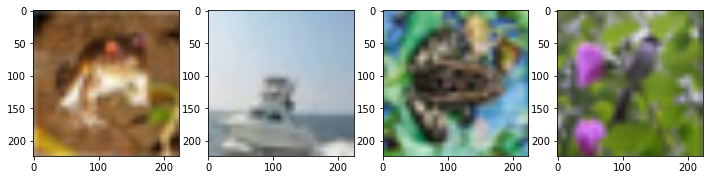

In [2]:
# データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# バッチサイズ、クラス数、エポック数の設定
batch_size=32
num_classes=10
epochs=5

# データリサイズ
img_rows=224
img_cols=224

x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train[::100,:,:,:]])
x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test[::100,:,:,:]])

# データ正規化
x_train=x_train.astype('float32')
x_train/=255
x_test=x_test.astype('float32')
x_test/=255

# one-hotベクトル化
y_train = y_train[::100]
y_test = y_test[::100]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(x_train[i]) for i in range(4)];

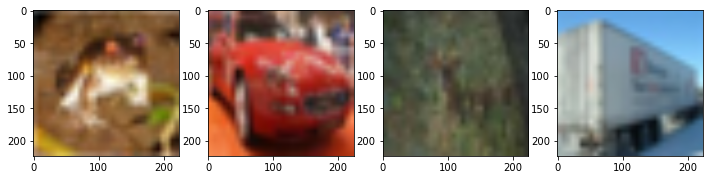

In [5]:
input_shape=(224, 224, 3)

model = Sequential()

# 第1層
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', input_shape=input_shape, name='block1_conv1'))
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', name='block1_conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block1_pool'))

# 第2層
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', name='block2_conv1'))
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', name='block2_conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block2_pool'))

# 第3層
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', name='block3_conv1'))
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', name='block3_conv2'))
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', name='block3_conv3'))
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', name='block3_conv4'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block3_pool'))

# 第4層
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block4_conv1'))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block4_conv2'))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block4_conv3'))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block4_conv4'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block4_pool'))

# 第5層
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block5_conv1'))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block5_conv2'))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block5_conv3'))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', name='block5_conv4'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same', name='block5_pool'))

# 全結合層
model.add(Flatten(name='flatten'))
model.add(Dense(units=4096, activation='relu', name='fc1'))
model.add(Dropout(0.5))
model.add(Dense(units=4096, activation='relu', name='fc2'))
model.add(Dropout(0.5))

# 出力層
model.add(Dense(units=num_classes, activation='softmax', name='predictions'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 128)     0

In [7]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,   
    patience=10, 
    min_lr=0.000001,
    verbose=2
)

sgd = SGD(lr=0.01, momentum=0.9, decay=5e-4, nesterov=False)

model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[reduce_lr])

Epoch 1/20


In [3]:
from keras.applications.vgg19 import VGG19

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[:17]:
    layer.trainable = False

In [5]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [4]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,   
    patience=10, 
    min_lr=0.000001,
    verbose=2
)

sgd = SGD(lr=0.01, momentum=0.9, decay=5e-4, nesterov=False)

model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

In [ ]:
history=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[reduce_lr])

Epoch 1/5


In [5]:
batch_size

32

torch.nn.modules.batchnorm.BatchNorm2d

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import random_split, DataLoader
import torchmetrics

from torchsummary import summary
import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy
import torchvision
from torchvision import models, transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] 指定されたプロシージャが見つかりません。
  warn(f"Failed to load image Python extension: {e}")


In [46]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.layers1 = []
        in_channels = 3
        
        # 第1層
        conv2d = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        
        # 第2層
        conv2d = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        
        # 第3層
        conv2d = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        
        # 第4層
        conv2d = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        
        # 第5層
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        conv2d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.layers1 += [conv2d, nn.ReLU(inplace=True)]
        self.layers1 += [nn.MaxPool2d(kernel_size=2, stride=2)]
        self.layers1 += [nn.AdaptiveAvgPool2d((7, 7))]
        self.features = nn.Sequential(*self.layers1)

        # 全結合層
        self.layers2 = []
        
        conv5 = nn.Linear(512*7*7, 4096)
        conv6 = nn.Linear(4096, 4096)
        conv7 = nn.Linear(4096, 10)
        self.layers2 += [conv5, nn.ReLU(inplace=True), nn.Dropout(p=0.5),
                         conv6, nn.ReLU(inplace=True), nn.Dropout(p=0.5), conv7]
        self.classifier = nn.Sequential(*self.layers2)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.shape[0], -1)
        out = self.classifier(out)
        return out

In [47]:
summary(VGG(), (3,224,224))

C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [39]:
class VGGTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = VGG()
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
        #return [optimizer,], [scheduler,]
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

In [1]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        self.dims = (3, 32, 32)
        self.num_classes = 10
    
    def prepare_data(self):
        CIFAR10(self.data_dir, train= True, download= True)
        CIFAR10(self.data_dir, train= False, download= True)
    
    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.cifar_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size)

NameError: name 'pl' is not defined

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


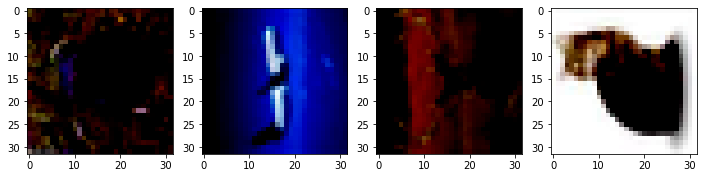

In [41]:
# Init our data pipeline
dm = CIFAR10DataModule(batch_size=32)
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(val_imgs[i].transpose(0,2)) for i in range(4)];

In [38]:
net = VGGTrainer().to(device)

trainer = pl.Trainer(gpus=0, max_epochs=5)

NameError: name 'VGGTrainer' is not defined

In [ ]:
trainer.fit(net, dm)

In [1]:
device

NameError: name 'device' is not defined

In [49]:
vgg19 = models.vgg19(pretrained=True)
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
class VGGTrainer(pl.LightningModule):
    def __init__(self):
        super(VGGTrainer, self).__init__()
        vgg19 = models.vgg19(pretrained=True)
        
        vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=10)
        self.model = vgg19
        
        update_param_names = ['classifier.6.weight', 'classifier.6.bias']
        
        for name, param in self.model.named_parameters():
            if name in update_param_names:
                param.requires_grad = True
            else:
                param.requires_grad = False
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)
        #return [optimizer,], [scheduler,]
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

In [ ]:
net = VGGTrainer().to(device)

trainer = pl.Trainer(gpus=0, max_epochs=5)

In [ ]:
trainer.fit(net, dm)